<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/notebooks/arima_garch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader as pdr

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Download Data

In [2]:
end_date = datetime.today()
# start_date = end_date + timedelta(days=-5*365)
start_date = datetime(2000, 1, 1)
spx = pdr.DataReader(name='^GSPC', data_source='yahoo', start=start_date, end=end_date)
hist_close = spx['Close']
hist_ret = hist_close / hist_close.shift(1) - 1.0     # shift 1 shifts forward one day; today has yesterday's price
# hist_ret = hist_close.pct_change(1)
hist_ret.dropna(inplace=True)
hist_ret = hist_ret * 100.0
print(hist_ret.describe())
print(f'Skew: {scipy.stats.skew(hist_ret)}, Kurtosis: {scipy.stats.kurtosis(hist_ret)}')

count    5155.000000
mean        0.022599
std         1.257874
min       -11.984055
25%        -0.478822
50%         0.056389
75%         0.573434
max        11.580037
Name: Close, dtype: float64
Skew: -0.14209031793258495, Kurtosis: 10.805446588849396


### ARIMA Model
#### Step One: Identify (p, d, q)

In [3]:
# price is known to be non-stationary; return is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(hist_close)
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')  # null hypothesis: unit root exists; can't reject null.

result = adfuller(hist_ret)
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')   # reject null hypothesis of unit root ==> stationary          

ADF Statistic: 0.5193392311354961, p-value: 0.985449193626401
ADF Statistic: -13.668804657981337, p-value: 1.473122279668348e-25


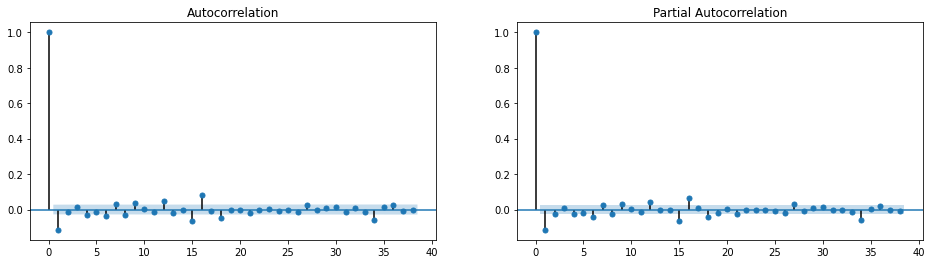

        acf      pacf
1 -0.115067 -0.115089
2 -0.011660 -0.025245
3  0.015008  0.010886
4 -0.029457 -0.027119
5 -0.014346 -0.020789


In [4]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 4))
plot_acf(hist_ret, ax=axes[0])          # determines MA(q)
plot_pacf(hist_ret, ax=axes[1])         # determines AR(p)
plt.show()

act_stats = acf(hist_ret, fft=False)[1:40]                
acf_df = pd.DataFrame([act_stats]).T
acf_df.columns = ['acf']
acf_df.index += 1

pacf_stats = pacf(hist_ret)[1:40]                        
pacf_df = pd.DataFrame([pacf_stats]).T
pacf_df.columns = ['pacf']
pacf_df.index += 1

df_acf_pcaf = pd.concat([acf_df, pacf_df], axis=1)
print(df_acf_pcaf.head())

In [5]:
# acf/pacf suggests higher order of arounds 35 business days; which makes the model practically unusable.
# instead, let's constraint the order to 5 business days and use AIC to pick up the best fit
from statsmodels.tsa.arima_model import ARIMA, ARMA

hist_training = hist_ret.iloc[:-45]
hist_testing = hist_ret.iloc[-45:]

dict_aic = {}
for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(hist_training, order=(p, 0, q))
            model_fit = model.fit(disp=0)
            dict_aic[(p, q)] = model_fit.aic
        except:
            pass
df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
p, q = df_aic[df_aic.aic == df_aic.aic.min()].index[0]
print(f'ARIMA order is ({p}, {0}, {q})')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA order is (5, 0, 5)


#### Step Two: Fit the Model

In [6]:
# train the selected model
model = ARIMA(hist_training, order=(p, 0, q))
arima_fitted = model.fit(disp=0)
arima_fitted.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5110
Model:                     ARMA(5, 5)   Log Likelihood               -8347.672
Method:                       css-mle   S.D. of innovations              1.239
Date:                Wed, 01 Jul 2020   AIC                          16719.343
Time:                        01:33:56   BIC                          16797.811
Sample:                             0   HQIC                         16746.815
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0212      0.014      1.471      0.141      -0.007       0.049
ar.L1.Close    -0.8244      0.140     -5.874      0.000      -1.100      -0.549
ar.L2.Close    -0.3461      0.184     -1.884      0.060      -0.706       0.014
ar.L3.Close    -0.5808      0.171     -3.400      0.001      -0.916      -0.246
ar.L4.Close    -0.1537      0.179     -0.857      0.392      -0.505       0.198
ar.L5.Close     0.4618      0.107      4.302      0.000       0.251       0.672
ma.L1.Close     0.7109      0.136      5.212      0.000       0.444       0.978
ma.L2.Close     0.2398      0.166      1.440      0.150      -0.087       0.566
ma.L3.Close     0.5423      0.152      3.566      0.000       0.244       0.840
ma.L4.Close     0.0584      0.165      0.354      0.723      -0.265       0.381
ma.L5.Close    -0.5215      0.097     -5.391      0.000      -0.711      -0.332
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9516           -0.4066j            1.0348           -0.4357
AR.2           -0.9516           +0.4066j            1.0348            0.4357
AR.3            0.2227           -1.0391j            1.0627           -0.2164
AR.4            0.2227           +1.0391j            1.0627            0.2164
AR.5            1.7906           -0.0000j            1.7906           -0.0000
MA.1           -0.9683           -0.4039j            1.0492           -0.4371
MA.2           -0.9683           +0.4039j            1.0492            0.4371
MA.3            0.2298           -1.0216j            1.0471           -0.2148
MA.4            0.2298           +1.0216j            1.0471            0.2148
MA.5            1.5891           -0.0000j            1.5891           -0.0000
-----------------------------------------------------------------------------
"""

#### Step Three: Residual Analysis

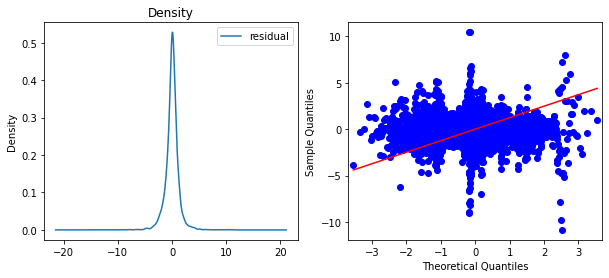

Statistics=993.870, p=0.000
Statistics=0.895, p=0.000


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [7]:
# unfortunately it doesn't look like Gaussian;
# which is somewhat expected, as acf/pacf graph has lags up to 2month ago.
residuals = pd.DataFrame(arima_fitted.resid, columns=['residual'])
fig, ax = plt.subplots(1,2, figsize=(10, 4))
# residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[0])
sm.qqplot(residuals, line='s', ax=ax[1])
plt.show()

# normality test
from scipy.stats import shapiro, normaltest
stat, p = normaltest(residuals)
print(f'Statistics={stat[0]:.3f}, p={p[0]:.3f}')       # H0: Gaussian
stat, p = shapiro(residuals)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian

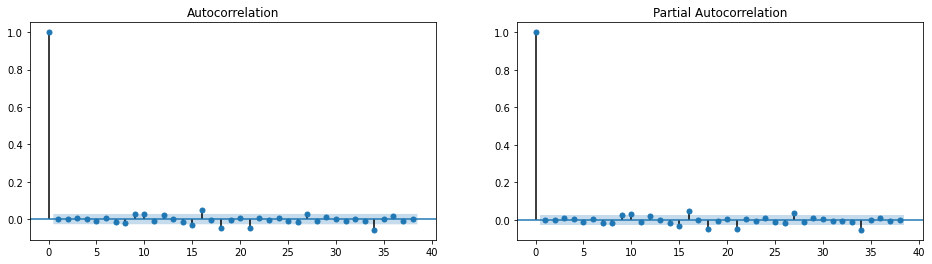

In [8]:
# Because we limit the lag orders; there still has remaining autocorrelation.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals, ax=axes[0])
plot_pacf(residuals, ax=axes[1])
plt.show()

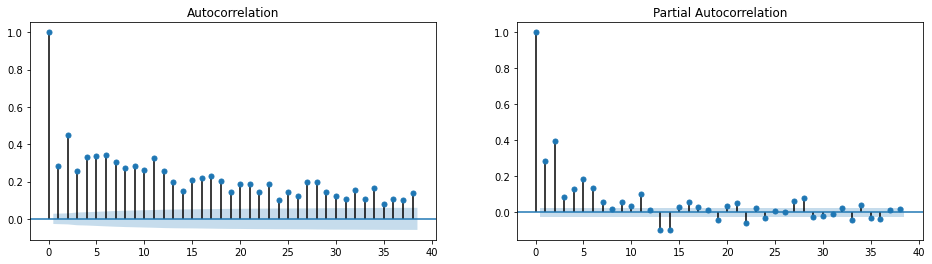

In [9]:
# In addition, There exists autocorrelation in squared residuals, suggesting GARCH
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals**2, ax=axes[0])
plot_pacf(residuals**2, ax=axes[1])
plt.show()

#### Step Four: Forecast

In [10]:
# The fit is on return. Errors are accumulated by cumprod
return_predicted = arima_fitted.predict()
price_predicted = hist_close[0]*np.cumprod(1+return_predicted/100.0)

In [11]:
forecasted, forecasted_std, forecasted_bounds = arima_fitted.forecast(hist_testing.shape[0])

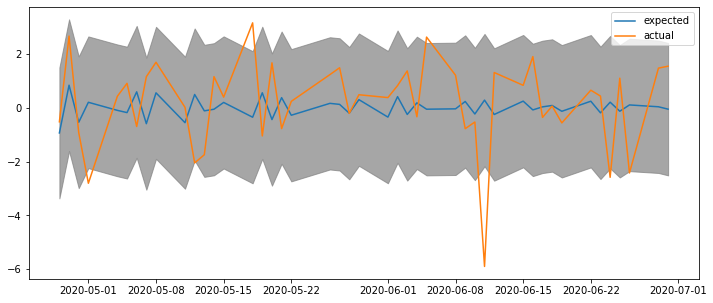

In [12]:
plt.figure(figsize=(12, 5))
return_expected = pd.DataFrame(forecasted, index=hist_testing.index)
return_lb = pd.DataFrame(forecasted_bounds[:, 0], index=hist_testing.index)
return_ub = pd.DataFrame(forecasted_bounds[:, 1], index=hist_testing.index)
plt.plot(return_expected, label='expected')
plt.plot(hist_testing, label='actual')
plt.fill_between(hist_testing.index, return_lb.values.reshape([-1]), return_ub.values.reshape([-1]), color='gray', alpha=0.7)
plt.legend()
plt.show()

### GARCH
[DOC](https://arch.readthedocs.io/en/latest/)
#### Step One: Identify Lag Orders

In [14]:
# !pip install arch

     |████████████████████████████████| 798kB 2.8MB/s 


In [15]:
from arch import arch_model
dict_aic = {}

for l in range(5):
    for p in range(1, 5):
        for q in range(1, 5):
            try:
                split_date = hist_ret.index[-45]
                model = arch_model(hist_ret, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
                res = model.fit(last_obs=split_date)
                dict_aic[(l, p, q)] = res.aic
            except:
                pass

df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
l, p, q = df_aic[df_aic.aic == df_aic.aic.min()].index[0]
print(f'ARIMA-GARCH order is ({l}, {p}, {q})')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7030.224152342767
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7024.528789814047
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7010.284602352095
Iteration:      4,   Func. Count:     32,   Neg. LLF: 7004.395988477274
Iteration:      5,   Func. Count:     39,   Neg. LLF: 6999.789356658235
Iteration:      6,   Func. Count:     46,   Neg. LLF: 6997.441419928551
Iteration:      7,   Func. Count:     53,   Neg. LLF: 6995.879581251908
Iteration:      8,   Func. Count:     60,   Neg. LLF: 6994.965077274485
Iteration:      9,   Func. Count:     66,   Neg. LLF: 6994.4796123100605
Iteration:     10,   Func. Count:     72,   Neg. LLF: 6994.1069661181
Iteration:     11,   Func. Count:     78,   Neg. LLF: 6994.0996327666735
Iteration:     12,   Func. Count:     84,   Neg. LLF: 6994.099570709919
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6994.099569793737
            Iterations: 12


#### Step Two: FIt the Model

In [16]:
model = arch_model(hist_ret, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:     12,   Neg. LLF: 6988.087542466911
Iteration:      2,   Func. Count:     30,   Neg. LLF: 6969.358366287802
Iteration:      3,   Func. Count:     46,   Neg. LLF: 6968.068998483201
Iteration:      4,   Func. Count:     61,   Neg. LLF: 6967.839193711193
Iteration:      5,   Func. Count:     76,   Neg. LLF: 6967.673052060971
Iteration:      6,   Func. Count:     90,   Neg. LLF: 6967.482702687801
Iteration:      7,   Func. Count:    105,   Neg. LLF: 6967.443143313605
Iteration:      8,   Func. Count:    119,   Neg. LLF: 6967.282713282093
Iteration:      9,   Func. Count:    133,   Neg. LLF: 6967.165963617786
Iteration:     10,   Func. Count:    146,   Neg. LLF: 6966.6094528791
Iteration:     11,   Func. Count:    160,   Neg. LLF: 6966.576509067985
Iteration:     12,   Func. Count:    173,   Neg. LLF: 6966.560012059228
Iteration:     13,   Func. Count:    186,   Neg. LLF: 6966.5564915464465
Iteration:     14,   Func. Count:    198,   Neg. LLF: 6966.555320

In [17]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.009
Mean Model:                        AR   Adj. R-squared:                  0.008
Vol Model:                      GARCH   Log-Likelihood:               -6966.56
Distribution:                  Normal   AIC:                           13953.1
Method:            Maximum Likelihood   BIC:                           14018.5
                                        No. Observations:                 5106
Date:                Wed, Jul 01 2020   Df Residuals:                     5096
Time:                        01:35:19   Df Model:                           10
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const           0.0711  1.181e-02      6.015  1.794e-09   [4.790e-02,9.420e-02]
Close[1]       -0.0612  1.452e-02     -4.214  2.513e-05 [-8.963e-02,-3.272e-02]
Close[2]       -0.0307  1.544e-02     -1.991  4.645e-02 [-6.100e-02,-4.833e-04]
Close[3]       -0.0105  1.502e-02     -0.702      0.483  [-3.999e-02,1.890e-02]
Close[4]   -8.6654e-03  1.547e-02     -0.560      0.575  [-3.899e-02,2.166e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0386  1.037e-02      3.720  1.993e-04 [1.825e-02,5.890e-02]
alpha[1]       0.0829  2.589e-02      3.204  1.357e-03   [3.220e-02,  0.134]
alpha[2]       0.1295  3.496e-02      3.703  2.134e-04   [6.093e-02,  0.198]
beta[1]        0.2733      0.426      0.642      0.521     [ -0.561,  1.108]
beta[2]        0.4874      0.379      1.285      0.199     [ -0.256,  1.231]
============================================================================

Covariance estimator: robust
"""

#### Step Three: Evaluate Model via Residuals

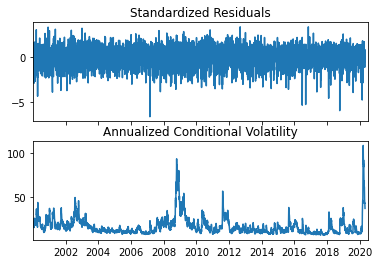

In [18]:
res.plot(annualize='D')
std_resid = res.resid / res.conditional_volatility
std_resid.dropna(inplace=True)

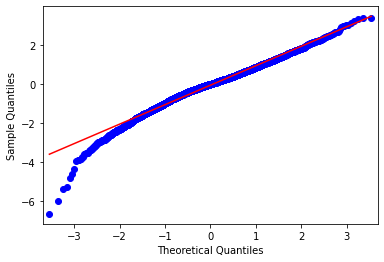

In [20]:
sm.qqplot(std_resid, line='s');

In [21]:
stat, p = normaltest(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian
stat, p = shapiro(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian

Statistics=385.475, p=0.000
Statistics=0.982, p=0.000


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Step Four: Forecast

In [22]:
forecasts = res.forecast(horizon=1, start=split_date)

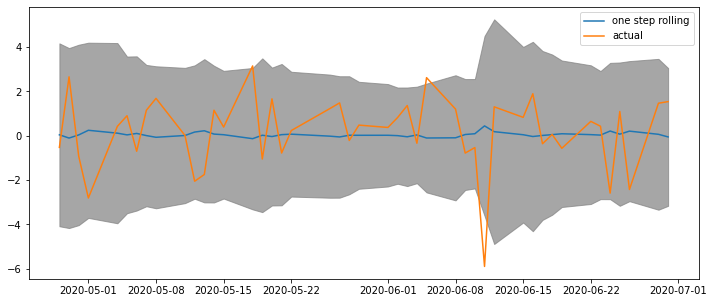

In [23]:
conf = np.sqrt(forecasts.variance[split_date:])*1.96

plt.figure(figsize=(12, 5))
plt.plot(forecasts.mean[split_date:], label='one step rolling')
plt.plot(hist_ret[split_date:], label='actual')
plt.fill_between(hist_ret[split_date:].index, (forecasts.mean[split_date:]-conf).values.reshape(-1), (forecasts.mean[split_date:]+conf).values.reshape(-1), color='gray', alpha=0.7)
plt.legend()
plt.show()